# Description

**We have data on users of Yandex.Afisha website. We have website visits log, orders log and the operation costs.
Our task is to find a way to optimize marketing expenses by studying how people use the website, when they stat to buy, how much money each customer brings and is it a profitable website.**

## Open the data files and study the general information. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
from scipy import stats as st
import numpy as np
import seaborn as sns
import difflib

In [2]:
try:
    visits_log = pd.read_csv('c:/Users/sagi3/OneDrive/שולחן העבודה/Data/Afisha project/visits_log_us.csv',
                             dtype = {'Device': 'category'},
                             parse_dates = ['Start Ts', 'End Ts'])
    orders_log = pd.read_csv('c:/Users/sagi3/OneDrive/שולחן העבודה/Data/Afisha project/orders_log_us.csv',
                            parse_dates = ['Buy Ts'])
    costs = pd.read_csv('c:/Users/sagi3/OneDrive/שולחן העבודה/Data/Afisha project/costs_us.csv',
                            parse_dates = ['dt'])
    
except:
    visits_log = pd.read_csv('/datasets/visits_log_us.csv',
                             dtype = {'Device': 'category'},
                             parse_dates = ['Start Ts', 'End Ts'])
    orders_log = pd.read_csv('/datasets/orders_log_us.csv',
                            parse_dates = ['Buy Ts'])
    costs = pd.read_csv('/datasets/costs_us.csv',
                            parse_dates = ['dt'])

In [3]:
visits_log.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Device     359400 non-null  category      
 1   End Ts     359400 non-null  datetime64[ns]
 2   Source Id  359400 non-null  int64         
 3   Start Ts   359400 non-null  datetime64[ns]
 4   Uid        359400 non-null  uint64        
dtypes: category(1), datetime64[ns](2), int64(1), uint64(1)
memory usage: 11.3 MB


In [4]:
orders_log.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Buy Ts   50415 non-null  datetime64[ns]
 1   Revenue  50415 non-null  float64       
 2   Uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


In [5]:
costs.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   int64         
 1   dt         2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


### Conclusion

**Read the csv files. Downloaded the data from the data set with 'datetime' type for dates columns and category type for the 'Device' columns in the visits table and 'source_id' in the costs table in order to reduce memory usage.**

**By a quick look we can see there are no missing values, But the columns names don't match the standard name format, so I need to change them.**

## Prepare the data

### Replace the column names

In [6]:
def column_change(df, placed_column, replaced_column):
    temp = df[replaced_column] 
    df[replaced_column] = df[placed_column]
    df[placed_column] = temp
    df.rename(columns = {placed_column:'temp'}, inplace = True)
    df.rename(columns = {replaced_column:placed_column}, inplace = True)
    df.rename(columns = {'temp':replaced_column}, inplace = True)

In [7]:
column_change(visits_log, 'Uid', 'Device')
column_change(visits_log, 'Source Id', 'End Ts')
column_change(visits_log, 'Device', 'End Ts')
column_change(visits_log, 'Source Id', 'Device')
visits_log.set_axis(['user_id', 'device', 'source_id', 'start_ts', 'end_ts'], axis = 1, inplace = True)
visits_log.head()

,user_id,device,source_id,start_ts,end_ts
0,16879256277535980062,touch,4,2017-12-20 17:20:00,2017-12-20 17:38:00
1,104060357244891740,desktop,2,2018-02-19 16:53:00,2018-02-19 17:21:00
2,7459035603376831527,touch,5,2017-07-01 01:54:00,2017-07-01 01:54:00
3,16174680259334210214,desktop,9,2018-05-20 10:59:00,2018-05-20 11:23:00
4,9969694820036681168,desktop,3,2017-12-27 14:06:00,2017-12-27 14:06:00


In [8]:
column_change(orders_log, 'Uid', 'Buy Ts')
orders_log.set_axis(['user_id','revenue', 'buy_ts'], axis = 1, inplace = True)
orders_log.head()

,user_id,revenue,buy_ts
0,10329302124590727494,17.00,2017-06-01 00:10:00
1,11627257723692907447,0.55,2017-06-01 00:25:00
2,17903680561304213844,0.37,2017-06-01 00:27:00
3,16109239769442553005,0.55,2017-06-01 00:29:00
4,14200605875248379450,0.37,2017-06-01 07:58:00


In [9]:
costs.set_axis(['source_id', 'date', 'cost'], axis = 1, inplace = True)
costs.head()

,source_id,date,cost
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


**After arranging the columns, I will prepare the data.**
**Visits_log: Make sure the visit duration is positive. end_ts - start_ts > 0**

In [10]:
visits_log['log_duration_min'] = (visits_log['end_ts'] - visits_log['start_ts']).dt.seconds / 60
visits_log = visits_log.query('log_duration_min > 0 & log_duration_min < 120')

In [11]:
visits_log.head()

,user_id,device,source_id,start_ts,end_ts,log_duration_min
0,16879256277535980062,touch,4,2017-12-20 17:20:00,2017-12-20 17:38:00,18.0
1,104060357244891740,desktop,2,2018-02-19 16:53:00,2018-02-19 17:21:00,28.0
3,16174680259334210214,desktop,9,2018-05-20 10:59:00,2018-05-20 11:23:00,24.0
5,16007536194108375387,desktop,5,2017-09-03 21:35:00,2017-09-03 21:36:00,1.0
6,6661610529277171451,desktop,1,2018-01-30 11:13:00,2018-01-30 12:09:00,56.0


### Conclusion

**Fixed the columns' order with the column_change function and changed the columns' names according to the name standard.
Also made sure all the log times are positive and lower than two hours because this logs are probably of users who opened the site, left it but didn't quit or they are away from keydoard/device.**

##  Make reports and calculate metrics

### Product

**Add session length**

In [12]:
visits_log['session_len_minutes'] = (visits_log['end_ts'] - visits_log['start_ts'])
visits_log['session_len_minutes'] = visits_log['session_len_minutes'].astype('timedelta64[m]')
visits_log['session_len_minutes'] = visits_log['session_len_minutes'].astype('int8')

**Add year, month, week and date columns**

In [13]:
visits_log['session_year']  = visits_log['start_ts'].dt.year
visits_log['session_month'] = visits_log['start_ts'].dt.month
visits_log['session_week']  = visits_log['start_ts'].dt.week
visits_log['session_date'] = visits_log['start_ts'].dt.date

/tmp/ipykernel_535/59261605.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  visits_log['session_week']  = visits_log['start_ts'].dt.week


#### Visits - DAU/WAU/MAU and sessions per day

##### DAU/WAU/MAU and average daily sessions

**Count total unique daily users and create dau table for the plot**

In [14]:
daily_total = visits_log.groupby(['session_date', 'session_week' ,'session_month', 'session_year']).agg({'user_id': 'nunique'}).reset_index()
daily_total.rename(columns = {'user_id':'daily_users'}, inplace = True)
dau = daily_total.copy()
dau['daily_users'] = dau['daily_users'].mean()
dau_num = dau.loc[0, 'daily_users']
dau = dau.groupby(['session_week','session_month', 'session_year']).mean()
dau = dau.sort_values(by = ['session_year', 'session_month', 'session_week'], ascending = True)

**Calculate the average dau for each week**

In [15]:
weekly_dau = daily_total.groupby(['session_week','session_month', 'session_year']).mean()
weekly_dau = weekly_dau.sort_values(by = ['session_year', 'session_month', 'session_week'], ascending = True)
weekly_dau.reset_index(inplace = True)
weekly_dau.rename(columns = {'daily_users':'weekly_dau'}, inplace = True)

**Count total unique weekly users and create wau table for the plot**

In [16]:
weekly_total = visits_log.groupby(['session_week' ,'session_month', 'session_year']).agg({'user_id': 'nunique'}).reset_index()
weekly_total.rename(columns = {'user_id':'weekly_users'}, inplace = True)
wau = weekly_total.copy()
wau['weekly_users'] = wau['weekly_users'].mean()
wau_num = wau.loc[0, 'weekly_users']
wau = wau.groupby(['session_month', 'session_year']).mean()
wau = wau.sort_values(by = ['session_year', 'session_month'], ascending = True)

**Calculate the averaage wau for each month**

In [17]:
monthly_wau = weekly_total.groupby(['session_month', 'session_year']).mean()
monthly_wau = monthly_wau.sort_values(by = ['session_year', 'session_month'], ascending = True)
monthly_wau.reset_index(inplace = True)
monthly_wau.rename(columns = {'weekly_users':'monthly_wau'}, inplace = True)

In [18]:
monthly_total = visits_log.groupby(['session_year', 'session_month']).agg({'user_id': 'nunique'}).reset_index()
monthly_total.rename(columns = {'user_id':'monthly_users'}, inplace = True)
monthly_total = monthly_total.groupby(['session_year', 'session_month']).mean()
mau = monthly_total.copy()
mau['monthly_users'] = mau['monthly_users'].mean()
mau = mau.reset_index()
mau_num = mau.loc[0, 'monthly_users']

**Count total daily sessions and create daily_avg table for the plot**

In [19]:
daily_sessions = visits_log.groupby(['session_date', 'session_week' ,'session_month', 'session_year']).agg({'user_id': 'count'}).reset_index()
daily_sessions.rename(columns = {'user_id':'daily_users'}, inplace = True)
daily_avg = daily_sessions.copy()
daily_avg['daily_users'] = daily_sessions['daily_users'].mean()
daily_avg_num = daily_avg.loc[0, 'daily_users']
daily_avg = daily_avg.groupby(['session_week','session_month', 'session_year']).mean()
daily_avg = daily_avg.sort_values(by = ['session_year', 'session_month', 'session_week'], ascending = True)

**Calculate the average number of sessions for each week**

In [20]:
weekly_sessions = daily_sessions.groupby(['session_week','session_month', 'session_year']).mean()
weekly_sessions = weekly_sessions.sort_values(by = ['session_year', 'session_month', 'session_week'], ascending = True)
weekly_sessions.reset_index(inplace = True)
weekly_sessions.rename(columns = {'daily_users':'daily_sessions'}, inplace = True)

In [21]:
dau

,,,daily_users
session_week,session_month,session_year,
22,6,2017,816.505495
23,6,2017,816.505495
24,6,2017,816.505495
25,6,2017,816.505495
26,6,2017,816.505495
...,...,...,...
18,5,2018,816.505495
19,5,2018,816.505495
20,5,2018,816.505495


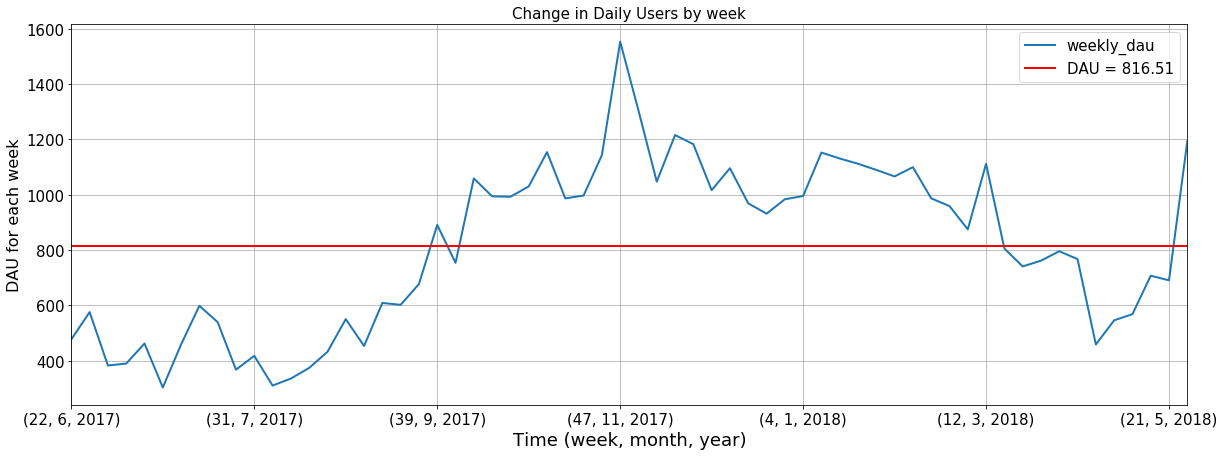

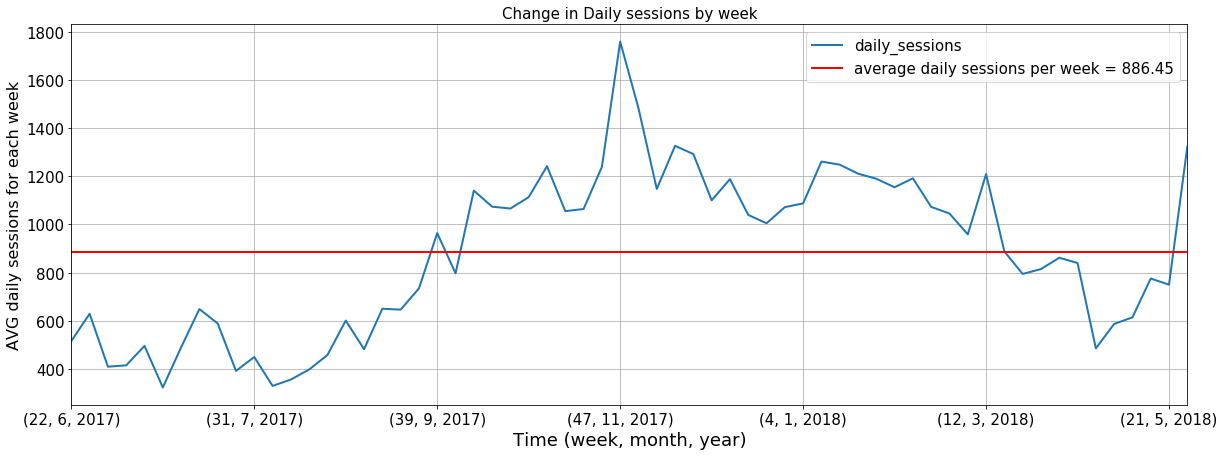

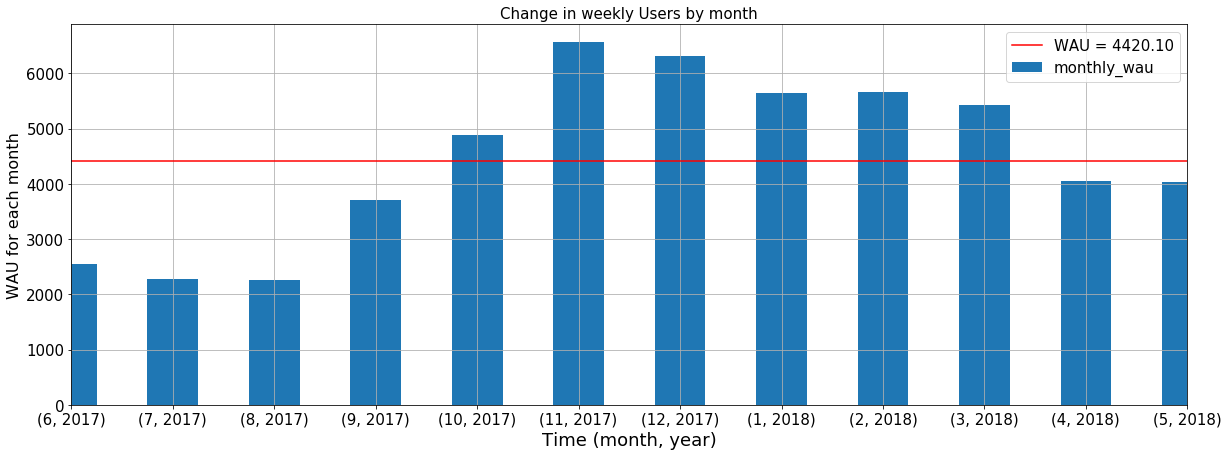

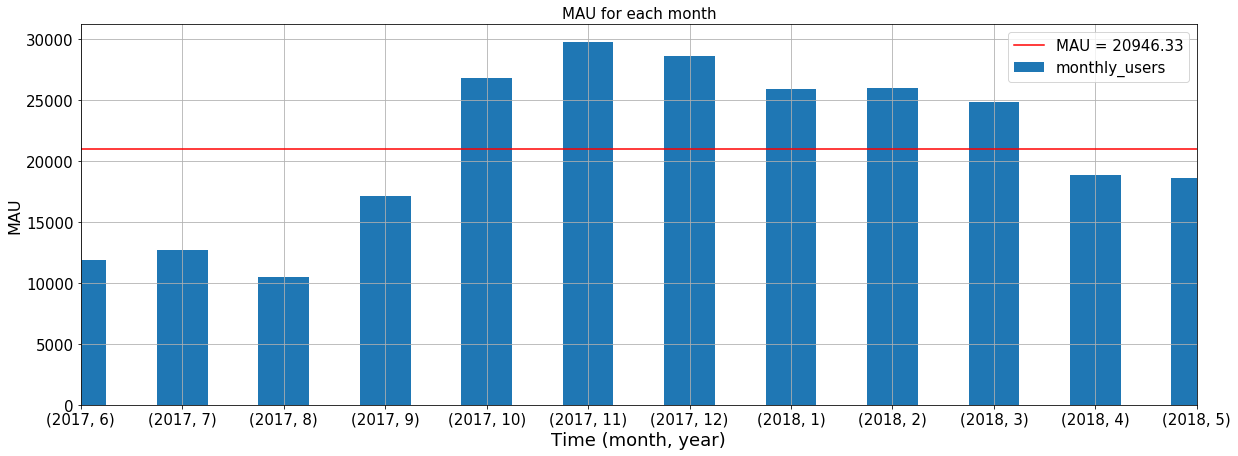

In [21]:
ax = weekly_dau.plot(y = 'weekly_dau', figsize = (20, 7), grid = True, fontsize = 15,   linewidth = 2)
dau.plot(y = 'daily_users',figsize = (20, 7), grid = True, fontsize = 15, color = 'r', ax = ax, label = 'DAU = {:.2f}'.format(dau_num), linewidth = 2)
plt.title('Change in Daily Users by week', fontsize = 15)
plt.xlabel('Time (week, month, year)', fontsize=18)
plt.ylabel('DAU for each week', fontsize=16)
plt.legend(prop={'size': 15})

ax = weekly_sessions.plot(y = 'daily_sessions', figsize = (20, 7), grid = True, fontsize = 15, linewidth = 2)
daily_avg.plot(y = 'daily_users',figsize = (20, 7), grid = True, fontsize = 15, color = 'r', ax = ax, label = 'average daily sessions per week = {:.2f}'.format(daily_avg_num), linewidth = 2)
plt.title('Change in Daily sessions by week', fontsize = 15)
plt.xlabel('Time (week, month, year)', fontsize=18)
plt.ylabel('AVG daily sessions for each week', fontsize=16)
plt.legend(prop={'size': 15})

ax = monthly_wau.plot(y = 'monthly_wau', figsize = (20, 7), grid = True, fontsize = 15, kind = 'bar')
wau.plot(y = 'weekly_users',figsize = (20, 7), grid = True, fontsize = 15, color = 'r', ax = ax, label = 'WAU = {:.2f}'.format(wau_num))
plt.title('Change in weekly Users by month', fontsize = 15)
plt.xlabel('Time (month, year)', fontsize=18)
plt.ylabel('WAU for each month', fontsize=16)
plt.legend(prop={'size': 15})

ax = monthly_total.plot(y = 'monthly_users', figsize = (20, 7), grid = True, fontsize = 15, kind = 'bar')
mau.plot( y = 'monthly_users', 
         figsize = (20, 7), grid = True, fontsize = 15, color = 'r', ax = ax, label = 'MAU = {:.2f}'.format(mau_num))
plt.xlabel('Time (month, year)', fontsize=18)
plt.ylabel('MAU', fontsize=16)
plt.title('MAU for each month', fontsize = 15)
plt.legend(prop={'size': 15})
plt.show()

**We can see from the graphs that we had top visitors numbers at the 11th month of 2017. We can assume that the rise in the visits is because it is the time of the holidays and people have time to search the web.
We can see that the average daily sessions is higher by around 70 than the DAU so we can tell some users return on the same day.**

##### Daily average sessions for each device by week

In [22]:
desktop_logs = visits_log.query('device == "desktop"')
desktop_sessions = desktop_logs.groupby(['session_date', 'session_week' ,'session_month', 'session_year']).agg({'user_id': 'count'}).reset_index()
desktop_users = desktop_logs.groupby(['session_date', 'session_week' ,'session_month', 'session_year']).agg({'user_id': 'nunique'}).reset_index()
desktop_sessions.rename(columns = {'user_id':'daily_desktop_sessions'}, inplace = True)
desktop_users.rename(columns = {'user_id':'daily_desktop_users'}, inplace = True)
desktop_users = desktop_users.filter(['session_date', 'daily_desktop_users'])
daily_desktop = desktop_sessions.merge(desktop_users, on = 'session_date')
daily_desktop['avg_user_sessions_daily'] = daily_desktop['daily_desktop_sessions'] / daily_desktop['daily_desktop_users']

desktop_avg = daily_desktop.copy()
desktop_avg['avg_user_sessions'] = desktop_avg['avg_user_sessions_daily'].mean()
desktop_avg_num = desktop_avg.loc[0, 'avg_user_sessions']
desktop_avg = desktop_avg.groupby(['session_week','session_month', 'session_year']).mean()
desktop_avg = desktop_avg.sort_values(by = ['session_year', 'session_month', 'session_week'], ascending = True)

weekly_desktop = daily_desktop.groupby(['session_week','session_month', 'session_year']).mean()
weekly_desktop = weekly_desktop.sort_values(by = ['session_year', 'session_month', 'session_week'], ascending = True)
weekly_desktop.reset_index(inplace = True)

In [23]:
touch_logs = visits_log.query('device == "touch"')
touch_sessions = touch_logs.groupby(['session_date', 'session_week' ,'session_month', 'session_year']).agg({'user_id': 'count'}).reset_index()
touch_users = touch_logs.groupby(['session_date', 'session_week' ,'session_month', 'session_year']).agg({'user_id': 'nunique'}).reset_index()
touch_sessions.rename(columns = {'user_id':'daily_touch_sessions'}, inplace = True)
touch_users.rename(columns = {'user_id':'daily_touch_users'}, inplace = True)
touch_users = touch_users.filter(['session_date', 'daily_touch_users'])
daily_touch = touch_sessions.merge(touch_users, on = 'session_date')
daily_touch['avg_user_sessions_daily'] = daily_touch['daily_touch_sessions'] / daily_touch['daily_touch_users']

touch_avg = daily_touch.copy()
touch_avg['avg_user_sessions'] = touch_avg['avg_user_sessions_daily'].mean()
touch_avg_num = touch_avg.loc[0, 'avg_user_sessions']
touch_avg = touch_avg.groupby(['session_week','session_month', 'session_year']).mean()
touch_avg = touch_avg.sort_values(by = ['session_year', 'session_month', 'session_week'], ascending = True)

weekly_touch = daily_touch.groupby(['session_week','session_month', 'session_year']).mean()
weekly_touch = weekly_touch.sort_values(by = ['session_year', 'session_month', 'session_week'], ascending = True)
weekly_touch.reset_index(inplace = True)

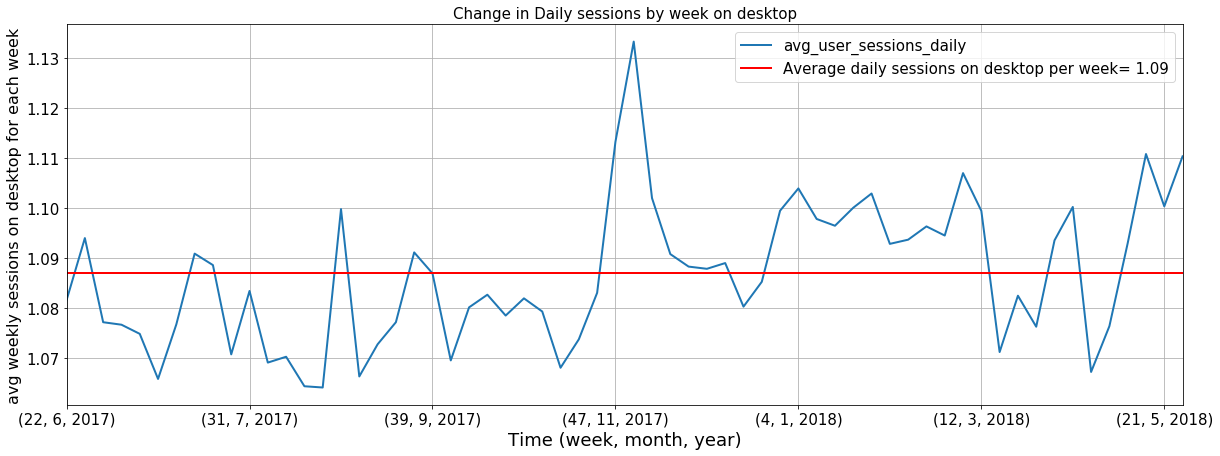

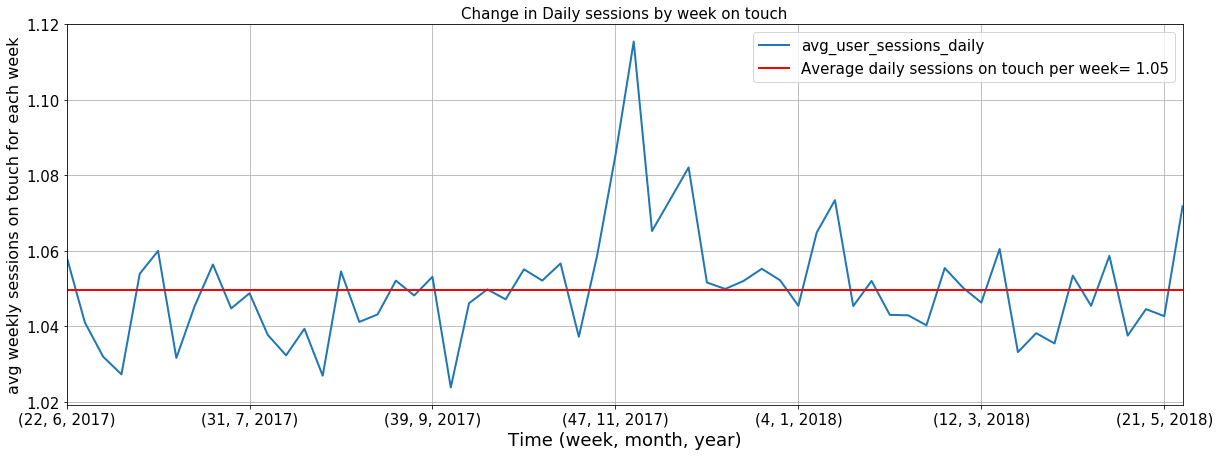

In [24]:
ax = weekly_desktop.plot(y = 'avg_user_sessions_daily', figsize = (20, 7), grid = True, fontsize = 15, linewidth = 2)
desktop_avg.plot(y = 'avg_user_sessions',figsize = (20, 7), grid = True, fontsize = 15, color = 'r', ax = ax, label = 'Average daily sessions on desktop per week= {:.2f}'.format(desktop_avg_num), linewidth = 2)
plt.title('Change in Daily sessions by week on desktop', fontsize = 15)
plt.xlabel('Time (week, month, year)', fontsize=18)
plt.ylabel('avg weekly sessions on desktop for each week', fontsize=16)
plt.legend(prop={'size': 15})

ax = weekly_touch.plot(y = 'avg_user_sessions_daily', figsize = (20, 7), grid = True, fontsize = 15, linewidth = 2)
touch_avg.plot(y = 'avg_user_sessions',figsize = (20, 7), grid = True, fontsize = 15, color = 'r', ax = ax, label = 'Average daily sessions on touch per week= {:.2f}'.format(touch_avg_num), linewidth = 2)
plt.title('Change in Daily sessions by week on touch', fontsize = 15)
plt.xlabel('Time (week, month, year)', fontsize=18)
plt.ylabel('avg weekly sessions on touch for each week', fontsize=16)
plt.legend(prop={'size': 15})

plt.show()

**As expected, the sessions by device looks very similar to the average daily sessions. We can see they have similar paths but differ in the number of sessions. the desktop use is much more popular.**

##### Daily average session length for each device by week 

In [25]:
desktop_len = desktop_logs.groupby(['session_date', 'session_week' ,'session_month', 'session_year']).agg({'session_len_minutes': 'mean'}).reset_index()
desktop_len.rename(columns = {'session_len_minutes':'daily_avg_len'}, inplace = True)


In [26]:
desktop_len

,session_date,session_week,session_month,session_year,daily_avg_len
0,2017-06-01,22,6,2017,12.969231
1,2017-06-02,22,6,2017,10.752174
2,2017-06-03,22,6,2017,12.498328
3,2017-06-04,22,6,2017,11.090615
4,2017-06-05,23,6,2017,11.866559
...,...,...,...,...,...
359,2018-05-27,21,5,2018,12.160858
360,2018-05-28,22,5,2018,11.436582
361,2018-05-29,22,5,2018,11.866084
362,2018-05-30,22,5,2018,12.036830


In [27]:
desktop_len = desktop_logs.groupby(['session_date', 'session_week' ,'session_month', 'session_year']).agg({'session_len_minutes': 'mean'}).reset_index()
desktop_len.rename(columns = {'session_len_minutes':'daily_avg_len'}, inplace = True)

desktop_avg_len = desktop_len.copy()
desktop_avg_len['daily_avg_len'] = desktop_avg_len['daily_avg_len'].mean()
desktop_avg_len_num = desktop_avg_len.loc[0, 'daily_avg_len']

desktop_avg_len = desktop_avg_len.groupby(['session_week','session_month', 'session_year']).mean()
desktop_avg_len = desktop_avg_len.sort_values(by = ['session_year', 'session_month', 'session_week'], ascending = True)

weekly_desktop_len = desktop_len.groupby(['session_week','session_month', 'session_year']).mean()
weekly_desktop_len = weekly_desktop_len.sort_values(by = ['session_year', 'session_month', 'session_week'], ascending = True)
weekly_desktop_len.reset_index(inplace = True)

In [28]:
touch_len = touch_logs.groupby(['session_date', 'session_week' ,'session_month', 'session_year']).agg({'session_len_minutes': 'mean'}).reset_index()
touch_len.rename(columns = {'session_len_minutes':'daily_avg_len'}, inplace = True)

touch_avg_len = touch_len.copy()
touch_avg_len['daily_avg_len'] = touch_avg_len['daily_avg_len'].mean()
touch_avg_len_num = touch_avg_len.loc[0, 'daily_avg_len']
touch_avg_len = touch_avg_len.groupby(['session_week','session_month', 'session_year']).mean()
touch_avg_len = touch_avg_len.sort_values(by = ['session_year', 'session_month', 'session_week'], ascending = True)

weekly_touch_len = touch_len.groupby(['session_week','session_month', 'session_year']).mean()
weekly_touch_len = weekly_touch_len.sort_values(by = ['session_year', 'session_month', 'session_week'], ascending = True)
weekly_touch_len.reset_index(inplace = True)

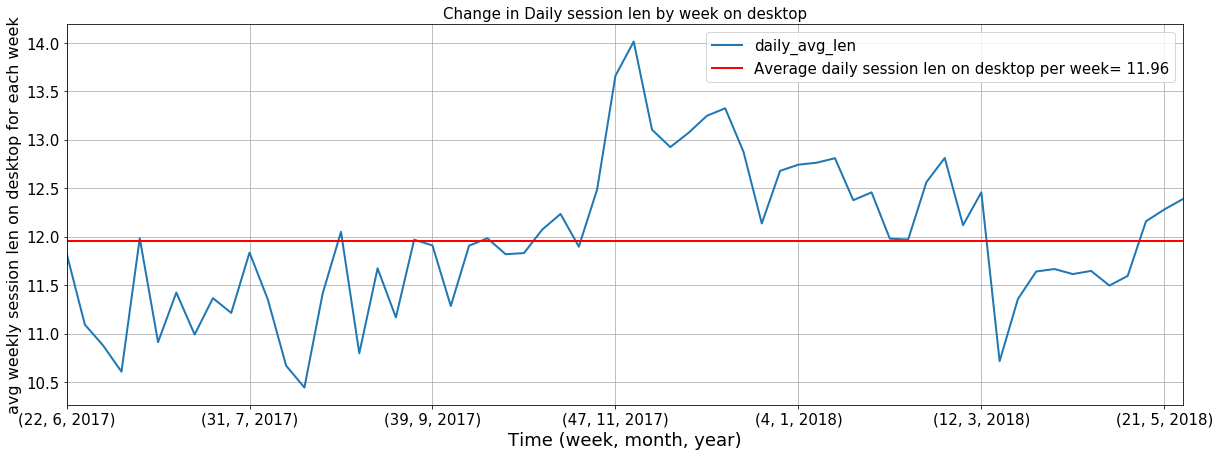

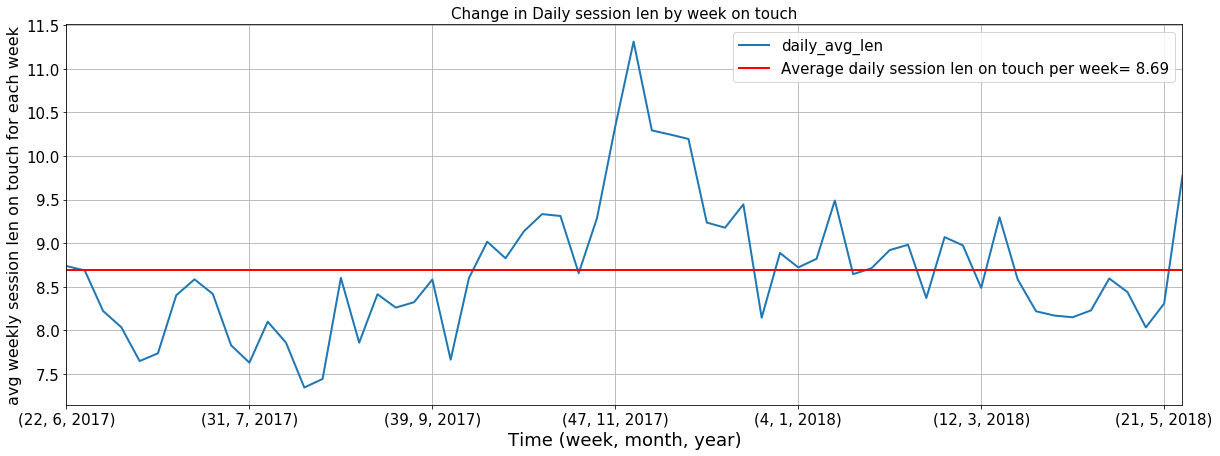

In [29]:
ax = weekly_desktop_len.plot(y = 'daily_avg_len', figsize = (20, 7), grid = True, fontsize = 15, linewidth = 2)
desktop_avg_len.plot(y = 'daily_avg_len',figsize = (20, 7), grid = True, fontsize = 15, color = 'r', ax = ax, label = 'Average daily session len on desktop per week= {:.2f}'.format(desktop_avg_len_num), linewidth = 2)
plt.title('Change in Daily session len by week on desktop', fontsize = 15)
plt.xlabel('Time (week, month, year)', fontsize=18)
plt.ylabel('avg weekly session len on desktop for each week', fontsize=16)
plt.legend(prop={'size': 15})


ax = weekly_touch_len.plot(y = 'daily_avg_len', figsize = (20, 7), grid = True, fontsize = 15, linewidth = 2)
touch_avg_len.plot(y = 'daily_avg_len',figsize = (20, 7), grid = True, fontsize = 15, color = 'r', ax = ax, label = 'Average daily session len on touch per week= {:.2f}'.format(touch_avg_len_num), linewidth = 2)
plt.title('Change in Daily session len by week on touch', fontsize = 15)
plt.xlabel('Time (week, month, year)', fontsize=18)
plt.ylabel('avg weekly session len on touch for each week', fontsize=16)
plt.legend(prop={'size': 15})

plt.show()

**As the desktop is more popular, the average session len on desktop is higher.**

#### Retention rates by first activity month and source_id

In [31]:
visits_log['activity_date'] = pd.to_datetime(visits_log['start_ts'])
first_activity_date = visits_log.groupby(['user_id'])['start_ts'].min()

In [32]:
first_activity_date.name = 'first_activity_date'
visits_log = visits_log.join(first_activity_date, on='user_id')

In [33]:
visits_log['first_activity_date'] = visits_log['first_activity_date'].dt.date
visits_log['activity_date'] = visits_log['activity_date'].dt.date

In [34]:
visits_log['first_activity_date'] = pd.to_datetime(visits_log['first_activity_date'])
visits_log['activity_date'] = pd.to_datetime(visits_log['activity_date'])

In [35]:
visits_log['first_activity_month'] = visits_log['first_activity_date'].astype('datetime64[M]')
visits_log['activity_month'] = visits_log['activity_date'].astype('datetime64[M]')

**Find the user's age by the time of a session**

In [36]:
visits_log['age_months'] = visits_log['activity_month'] - visits_log['first_activity_month']
visits_log['age_months'] = visits_log['age_months'] / np.timedelta64(1, 'M')
visits_log['age_months'] = visits_log['age_months'].round().astype(int)

**Create cohort by the first_activity_month and age_months**

In [37]:
cohorts = visits_log.groupby(['first_activity_month', 'age_months']).agg({'user_id': 'nunique'}).reset_index()
initial_users_count = cohorts[cohorts['age_months'] == 0][['first_activity_month', 'user_id']]
initial_users_count = initial_users_count.rename(columns={'user_id': 'cohort_users'}) 
cohorts = cohorts.merge(initial_users_count, on='first_activity_month') 
cohorts['retention'] = cohorts['user_id'] / cohorts['cohort_users'] 
retention_pivot_first_activity = cohorts.pivot_table(index = 'first_activity_month', columns = 'age_months', values='retention', aggfunc = 'sum')
retention_pivot_first_activity.index = retention_pivot_first_activity.index.date

**Create cohort by the source_id and age_months**

In [38]:
source_ret = visits_log.groupby(['source_id', 'age_months']).agg({'user_id': 'nunique'}).reset_index()
initial_users_count = source_ret[source_ret['age_months'] == 0][['source_id', 'user_id']]
initial_users_count = initial_users_count.rename(columns={'user_id': 'cohort_users'}) 
source_ret = source_ret.merge(initial_users_count, on='source_id') 
source_ret['retention'] = source_ret['user_id'] / source_ret['cohort_users'] 
retention_pivot_by_source = source_ret.pivot_table(index = 'source_id', columns = 'age_months', values='retention', aggfunc = 'sum')
retention_pivot_by_source.index = retention_pivot_by_source.index.astype(int)
retention_pivot_by_source.sort_index(ascending = True, axis = 0, inplace = True)
retention_pivot_by_source.index = retention_pivot_by_source.index.astype('category')

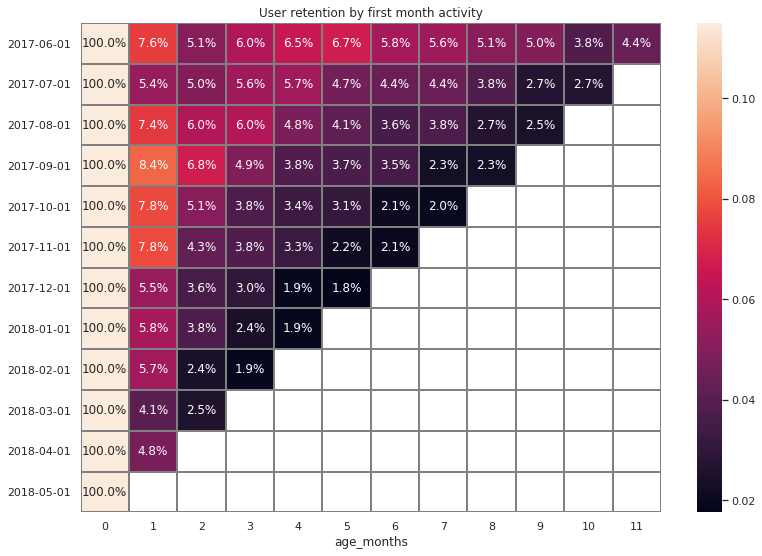

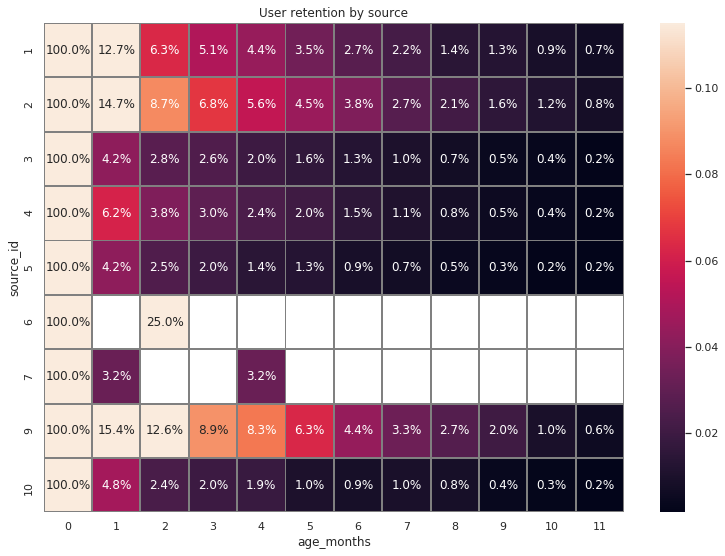

In [39]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('User retention by first month activity')
sns.heatmap(retention_pivot_first_activity, annot=True, fmt='.1%', linewidths = 1, linecolor = 'gray', vmax = 0.115)

sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('User retention by source')
sns.heatmap(retention_pivot_by_source, annot=True, fmt='.1%', linewidths = 1, linecolor = 'gray', vmax = 0.115)
plt.show()

**Very small percentage of the visitors return to our sight. maybe it's because the character of our service and users only need it once.
Sources 1, 2 and 9 produce the most retention**

#### Conclusion 

**Most of the users use our website at around november and at that time they also stay longer in our site.
Most of them use computers and come from sources 1,2 and 9.
For some reason the retention rate is low.**

### Sales

#### Conversion time

**Find first activity and first purchase time and calculate the conversion time**
**Added the device and source_id to check conversion time for different devices and sources.**

In [40]:
first_activity_info = visits_log.filter(['user_id', 'device', 'source_id', 'start_ts'])
first_activity_date = visits_log.groupby(['user_id'])['start_ts'].min().reset_index()


first_purchase_date = orders_log.groupby(['user_id'])['buy_ts'].min()

conversion_time =  first_activity_date.merge(first_purchase_date, on = 'user_id', how = 'right')
conversion_time = conversion_time.merge(first_activity_info, on = ['user_id', 'start_ts'], how = 'left')

conversion_time['conversion_time'] = (conversion_time['buy_ts'] - conversion_time['start_ts']) / np.timedelta64(1, 'D')
conversion_time['conversion_time'] = conversion_time['conversion_time'].fillna(0)
conversion_time['conversion_time'] = conversion_time['conversion_time'].apply(np.floor).astype('int8')
conversion_time.loc[conversion_time['conversion_time'] < 0,'conversion_time'] = 0
conversion_time.sort_values(by = 'conversion_time', ascending = False).head()

,user_id,start_ts,buy_ts,device,source_id,conversion_time
12505,6325671934104753634,2017-09-26 15:51:00,2018-02-01 15:40:00,desktop,3.0,127
12483,6312760469678681280,2017-10-07 22:54:00,2018-02-12 21:13:00,desktop,2.0,127
31549,16136459944502497115,2017-09-12 11:35:00,2018-01-17 19:34:00,desktop,3.0,127
5064,2600100290035900877,2017-11-26 22:32:00,2018-04-03 20:57:00,desktop,9.0,127
10958,5579250741107043745,2017-06-05 21:35:00,2017-10-11 01:26:00,touch,4.0,127


**Looks like some customers' conversion time was long and even exceeded 100 days. those are probably anomalies so I will drop the outliers**

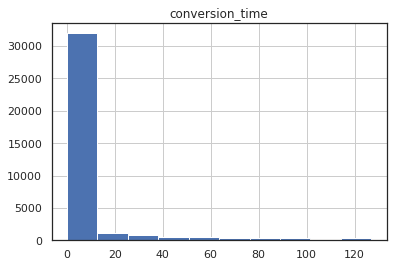

In [41]:
conversion_time.hist('conversion_time', bins = 10)
plt.show()

**A big part of the users have 0 for conversion time. looks like our funnels work well for oour customers.
Let's see how many percentage of the users don't find our funnels comfortable** 

In [42]:
print('percentage of conversion time longer than 1 day: {:.2%}'.format(len(conversion_time[conversion_time['conversion_time'] > 1]) / len(conversion_time)))

percentage of conversion time longer than 1 day: 19.66%


**Almost 20 percent, maybe they weren't sure about the perchase when they first visited.**

In [43]:
conversion_source = pd.DataFrame(data = conversion_time.groupby('source_id')['conversion_time'].mean()) 
conversion_source

,conversion_time
source_id,
1.0,4.646366
2.0,8.939454
3.0,7.685153
4.0,7.316858
5.0,5.750110
7.0,0.000000
9.0,19.193906
10.0,4.824159


**Looks like none of the buyers arrived from source_id 6**

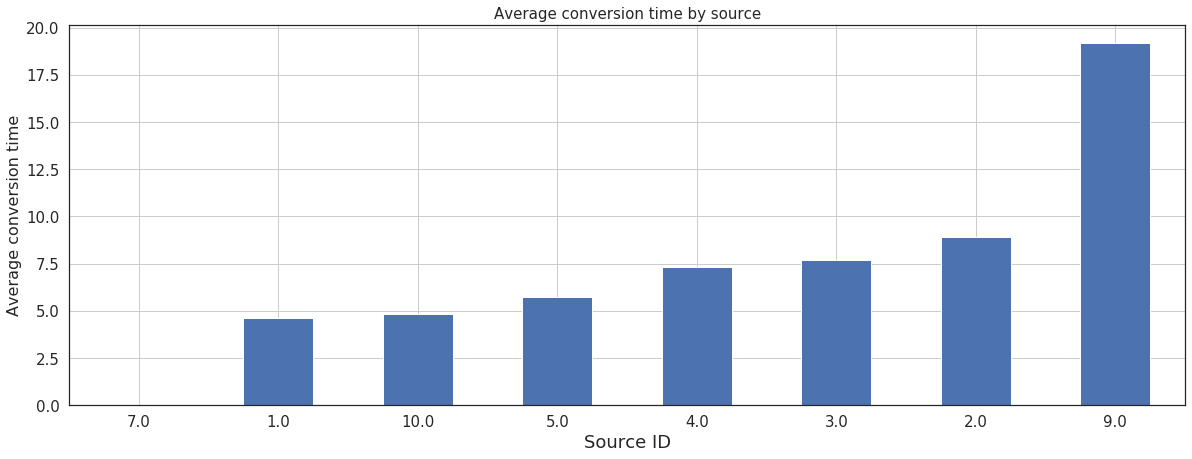

In [44]:
conversion_source.dropna(inplace = True)
conversion_source = conversion_source.sort_values(by = 'conversion_time', ascending = True)
conversion_source['conversion_time'].plot(figsize = (20, 7), grid = True, fontsize = 15, kind = 'bar', rot = 0)
plt.title('Average conversion time by source', fontsize = 15)
plt.xlabel('Source ID', fontsize=18)
plt.ylabel('Average conversion time', fontsize=16)
plt.show()

**Source 9 has the highest conversion time by far, we will need to see how the source serves the target audience.
Source 7 has suspiciously low conversion rate so we will need to see how many users actually come from it.** 

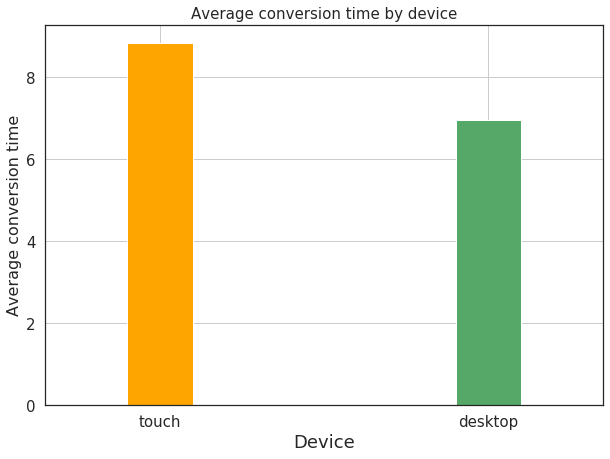

In [45]:
conversion_device = pd.DataFrame(data = conversion_time.groupby('device')['conversion_time'].mean()) 
conversion_device = conversion_device.sort_values(by = 'conversion_time', ascending = False)
conversion_device['conversion_time'].plot(figsize = (10, 7), grid = True, fontsize = 15, kind = 'bar', rot = 0, width = 0.2, color = ['orange', 'g'])
plt.title('Average conversion time by device', fontsize = 15)
plt.xlabel('Device', fontsize=18)
plt.ylabel('Average conversion time', fontsize=16)
plt.show()

**The conversion time on desktop is lower than in touch. Maybe because scrolling on the phone is more casual activity and people somtimes wander and looking around instead of iinstantly buying.**

##### Conclusion

**The conversion time for 80% of the buyers is 0. I think it's great and our users find the website pleasant.
It is important to notice there were no purchases from source 6 so we will have to look in to it in the LTV by source.
We also need to take a look at source 9 and see how we can improve the usage of it. Maybe source 9 is on mobile so the touch users comes from it thus the touch conversion time is higher.**

#### How many orders users make over a given period of time?


In [46]:
orders_log['purchase_date'] = pd.to_datetime(orders_log['buy_ts'])

In [47]:
first_purchase_date.name = 'first_purchase_date'
orders_log = orders_log.join(first_purchase_date, on='user_id')

In [48]:
orders_log['first_purchase_date'] = orders_log['first_purchase_date'].dt.date
orders_log['purchase_date'] = orders_log['purchase_date'].dt.date

In [49]:
orders_log['first_purchase_date'] = pd.to_datetime(orders_log['first_purchase_date'])
orders_log['purchase_date'] = pd.to_datetime(orders_log['purchase_date'])

In [50]:
orders_log['first_purchase_month'] = orders_log['first_purchase_date'].astype('datetime64[M]')
orders_log['purchase_month'] = orders_log['purchase_date'].astype('datetime64[M]')

In [51]:
orders_log['age_months'] = orders_log['purchase_month'] - orders_log['first_purchase_month']
orders_log['age_months'] = orders_log['age_months'] / np.timedelta64(1, 'M')
orders_log['age_months'] = orders_log['age_months'].round().astype(int)

In [52]:
cohorts_purchases = orders_log.groupby(['first_purchase_month', 'age_months']).agg({'user_id': 'count'}).reset_index()
initial_purchase_count = cohorts_purchases[cohorts_purchases['age_months'] == 0][['first_purchase_month', 'user_id']]
initial_purchase_count = initial_purchase_count.rename(columns={'user_id': 'cohort_users'}) 
cohorts_purchases = cohorts_purchases.merge(initial_purchase_count, on='first_purchase_month') 

In [53]:
cohorts_number = orders_log.groupby(['first_purchase_month', 'age_months']).agg({'user_id': 'nunique'}).reset_index()
initial_purchase_count = cohorts_number[cohorts_number['age_months'] == 0][['first_purchase_month', 'user_id']]
initial_purchase_count = initial_purchase_count.rename(columns={'user_id': 'cohort_users'}) 
cohorts_number = cohorts_number.merge(initial_purchase_count, on='first_purchase_month') 

In [54]:
cohorts = (cohorts_purchases.filter(['user_id', 'cohort_users']) / cohorts_number.filter(['user_id', 'cohort_users'])).round(decimals = 2)

cohorts_number = cohorts_number.filter(['first_purchase_month', 'age_months'])

cohorts = cohorts.join(cohorts_number)

pivot_first_purchase = cohorts.pivot_table(index = 'first_purchase_month', columns = 'age_months', values='user_id', aggfunc = 'sum')
pivot_first_purchase.index = pivot_first_purchase.index.date

pivot_first_purchase = pivot_first_purchase.drop(pd.to_datetime('2018-06-01'))

In [55]:
mean = pd.DataFrame(data = pivot_first_purchase.mean(axis = 1).round(decimals = 2))
mean.index.name = 'age_months'
pivot_first_purchase = pd.merge(pivot_first_purchase, mean, left_index=True, right_index=True)
pivot_first_purchase.set_axis(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', 'mean'], axis = 1, inplace = True)
pivot_first_purchase.fillna('') 

,0,1,2,3,4,5,6,7,8,9,10,11,mean
age_months,,,,,,,,,,,,,
2017-06-01,1.16,2.9,3.48,4.19,3.32,3.25,4.45,3.7,3.66,3.4,2.13,1.62,3.11
2017-07-01,1.14,1.92,2.11,1.62,1.47,2.16,1.69,1.28,1.38,1.09,2.04,,1.63
2017-08-01,1.12,1.86,1.89,1.84,2.12,1.94,1.63,1.77,2.42,1.48,,,1.81
2017-09-01,1.14,1.68,1.61,2.22,1.29,1.7,1.64,1.51,1.42,,,,1.58
2017-10-01,1.14,1.52,1.32,1.33,1.39,1.43,1.54,1.87,,,,,1.44
2017-11-01,1.18,1.79,1.52,1.99,1.68,1.23,1.65,,,,,,1.58
2017-12-01,1.15,1.85,1.96,1.85,1.72,1.67,,,,,,,1.70
2018-01-01,1.12,1.96,1.92,1.49,1.73,,,,,,,,1.64
2018-02-01,1.12,1.88,1.43,1.79,,,,,,,,,1.56


**Looks like the customers who started purchasing at the first month are the most loyal. They keep purchasing in higher volumes and have higher mean. maybe they recived some kind of special offer that others didn't. maybe we can make special offers to the other cohorts.**

#### What is the average purchase size?



In [56]:
cohorts = visits_log.groupby(['first_activity_month', 'age_months']).agg({'user_id': 'nunique'}).reset_index()
initial_users_count = cohorts[cohorts['age_months'] == 0][['first_activity_month', 'user_id']]
initial_users_count = initial_users_count.rename(columns={'user_id': 'cohort_users'}) 
cohorts = cohorts.merge(initial_users_count, on='first_activity_month') 
cohorts['retention'] = cohorts['user_id'] / cohorts['cohort_users'] 
retention_pivot_first_activity = cohorts.pivot_table(index = 'first_activity_month', columns = 'age_months', values='retention', aggfunc = 'sum')
retention_pivot_first_activity.index = retention_pivot_first_activity.index.date

In [57]:
cohorts_purchases = orders_log.groupby(['first_purchase_month', 'age_months']).agg({'user_id': 'count'}).reset_index()
initial_purchase_count = cohorts_purchases[cohorts_purchases['age_months'] == 0][['first_purchase_month', 'user_id']]
initial_purchase_count = initial_purchase_count.rename(columns={'user_id': 'total_revenue'}) 
cohorts_purchases = cohorts_purchases.rename(columns={'user_id': 'revenue'}) 
cohorts_purchases = cohorts_purchases.merge(initial_purchase_count, on='first_purchase_month') 

In [58]:
cohorts_revenue = orders_log.groupby(['first_purchase_month', 'age_months']).agg({'revenue': 'sum'}).reset_index()
initial_purchase_revenue = cohorts_revenue[cohorts_purchases['age_months'] == 0][['first_purchase_month', 'revenue']]
initial_purchase_revenue = initial_purchase_revenue.rename(columns={'revenue': 'revenue_total'}) 
cohorts_revenue = cohorts_revenue.merge(initial_purchase_revenue, on='first_purchase_month') 

In [59]:
cohorts = (cohorts_revenue.filter(['revenue', 'revenue_total']) / cohorts_purchases.filter(['revenue', 'revenue_total'])).round(decimals = 2)

cohorts_number = cohorts_number.filter(['first_purchase_month', 'age_months'])

cohorts = cohorts.join(cohorts_number)

pivot_first_purchase = cohorts.pivot_table(index = 'first_purchase_month', columns = 'age_months', values='revenue', aggfunc = 'mean')
pivot_first_purchase.index = pivot_first_purchase.index.date

pivot_first_purchase = pivot_first_purchase.drop(pd.to_datetime('2018-06-01'))

In [60]:
mean = pd.DataFrame(data = pivot_first_purchase.mean(axis = 1).round(decimals = 2))
mean.index.name = 'age_months'
pivot_first_purchase = pd.merge(pivot_first_purchase, mean, left_index=True, right_index=True)
pivot_first_purchase.set_axis(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', 'mean'], axis = 1, inplace = True)
pivot_first_purchase.fillna('') 

,0,1,2,3,4,5,6,7,8,9,10,11,mean
age_months,,,,,,,,,,,,,
2017-06-01,4.06,5.55,5.09,8.55,7.08,6.83,6.97,6.76,5.28,8.01,12.04,6.04,6.86
2017-07-01,5.29,6.45,9.99,6.64,4.72,3.66,3.79,5.45,5.35,11.79,5.65,,6.25
2017-08-01,4.72,5.99,6.28,6.62,7.96,6.27,5.89,7.11,8.7,5.6,,,6.51
2017-09-01,4.97,13.17,8.35,62.57,15.43,15.32,16.77,11.21,7.79,,,,17.29
2017-10-01,4.37,7.41,5.13,5.59,5.1,5.07,4.28,4.01,,,,,5.12
2017-11-01,4.37,4.1,4.47,6.28,4.44,3.73,4.6,,,,,,4.57
2017-12-01,4.11,4.23,20.07,26.08,15.95,14.11,,,,,,,14.09
2018-01-01,3.69,4.44,6.45,7.52,2.71,,,,,,,,4.96
2018-02-01,3.71,4.58,3.45,3.87,,,,,,,,,3.90


**We have high revenue for user in september and december 2017.**

##### Conclusion

**We have higher purchases per user in the first months but it looks like in the 9-12 months of 2017 we had higher revenue for user. So we should see what we did better back then.**

#### LTV


In [61]:
first_orders = orders_log.groupby('user_id').agg({'purchase_month': 'min'}).reset_index()
first_orders.columns = ['user_id', 'first_order_month']

In [62]:
cohort_sizes = first_orders.groupby('first_order_month').agg({'user_id': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']

In [63]:
purchases = pd.merge(orders_log, first_orders, on = 'user_id')
cohorts = purchases.groupby(['first_order_month','purchase_month']).agg({'revenue': 'sum'}).reset_index()
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')

In [64]:
report['age'] = (report['purchase_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')

In [65]:
report['ltv'] = report['revenue'] / report['n_buyers']
output = report.pivot_table(index='first_order_month', columns='age', values='ltv', aggfunc='mean').cumsum(axis=1)
output.index = output.index.date

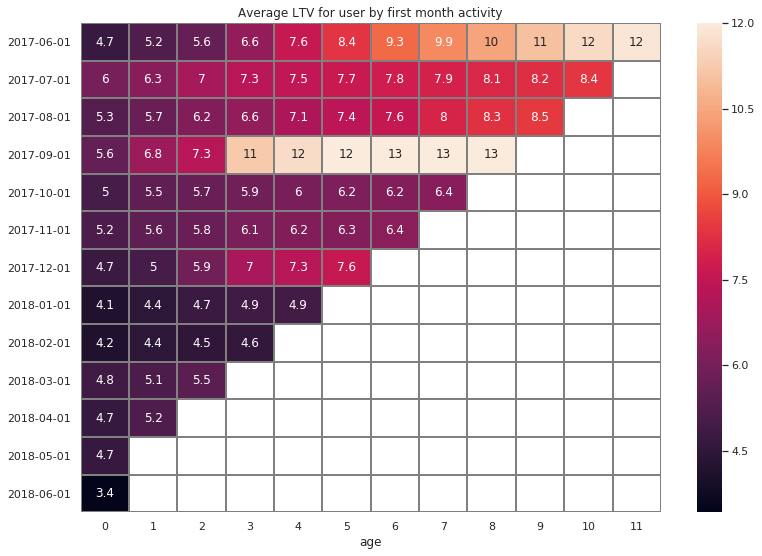

In [66]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Average LTV for user by first month activity')
sns.heatmap(output, annot = True, linewidths = 1, linecolor = 'gray', vmax = 12)
plt.show()

**Seeing the first results of revenue by customer. We have higher LTV for customers who made their first purchase in June, September and December 2017.**

In [67]:
source = conversion_time.merge(orders_log, on = 'user_id')
source = source.query('source_id.notna()')
source_revenue = source.groupby('source_id').agg({'revenue':'sum'})
source_users = source.groupby('source_id').agg({'user_id':'nunique'})
source_ltv = source_revenue.merge(source_users, on = 'source_id')
source_ltv['ltv'] = source_ltv['revenue'] / source_ltv['user_id']
source_ltv.filter(['source_id', 'ltv'], axis = 1)

,ltv
source_id,
1.0,10.222830
2.0,13.476899
3.0,5.178321
4.0,5.497080
5.0,7.791773
7.0,1.220000
9.0,5.261727
10.0,3.560367


**In the source LTV we can see that sources number 1 and 2 have significantly higher LTV and it seems like source 7 dosen't have a lot of value compared to them.**

#### Conclusion

**The conversion time for 80% of the buyers is 0. I think it's great and our users find the website pleasant.
It is important to notice there were no purchases from source 6 so we will have to look in to it in the LTV by source.
We also need to take a look at source 9 and see how we can improve the usage of it. Maybe source 9 is on mobile so the touch users comes from it thus the touch conversion time is higher.**

**We have higher purchases per user in the first months but it looks like in the 9-12 months of 2017 we had higher revenue for user. So we should see what we did better back then.**

**We have higher LTV for customers who made their first purchase in June, September and December 2017.**

### Marketing

#### Expenses on marketing

In [68]:
costs['month'] = costs['date'].astype('datetime64[M]')

In [69]:
monthly_costs = costs.groupby('month')['cost'].sum().reset_index()
monthly_costs['total_cost'] = 0
monthly_costs.loc[0, 'total_cost'] = monthly_costs.loc[0, 'cost']
monthly_costs['month'] = monthly_costs['month'].dt.date

In [70]:
for element in range(1, len(monthly_costs)):
    monthly_costs.loc[element, 'total_cost'] = monthly_costs.loc[element - 1, 'total_cost'] + monthly_costs.loc[element, 'cost']

In [71]:
total = monthly_costs.loc[11, 'total_cost']

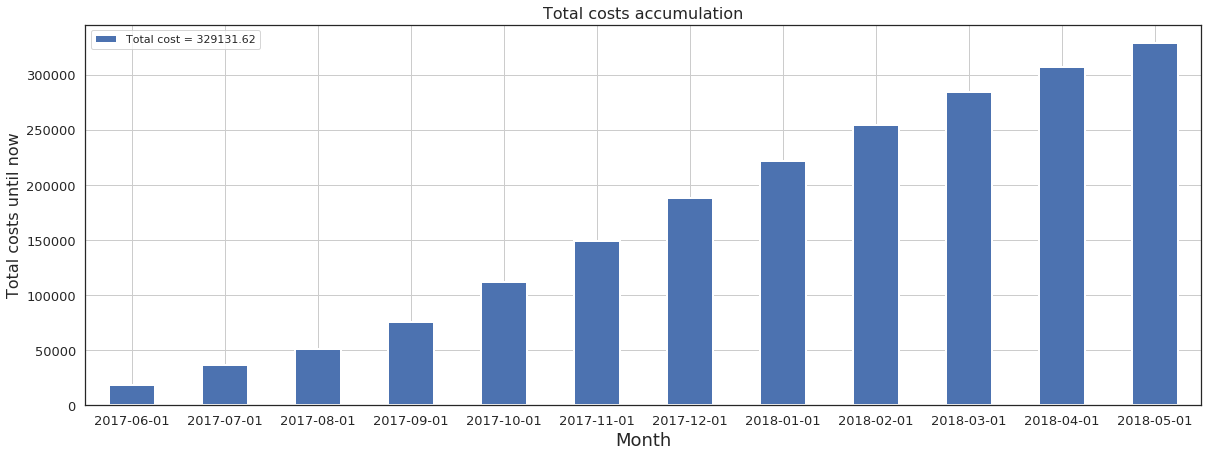

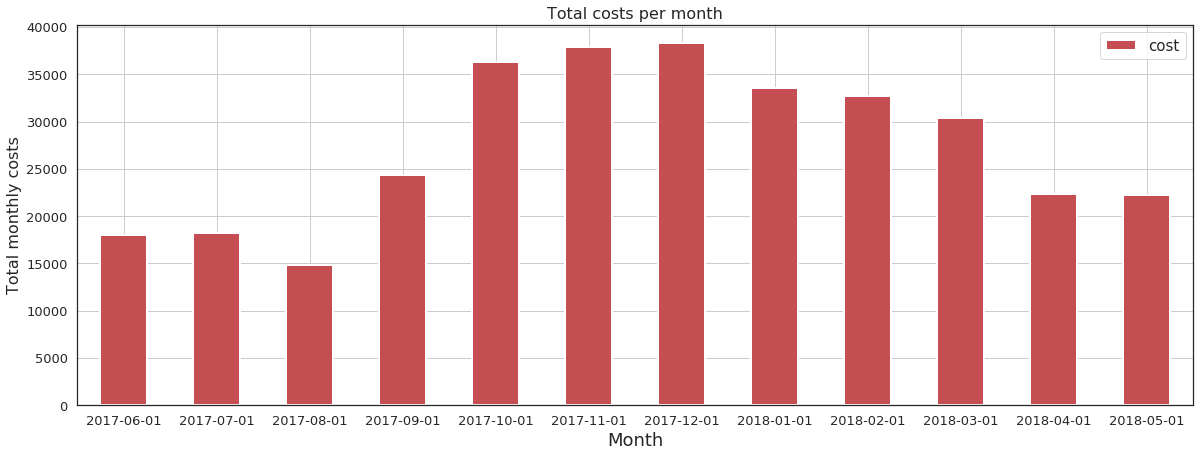

In [72]:
ax = monthly_costs.plot(x = 'month', y = 'total_cost', figsize = (20, 7), grid = True, fontsize = 13, linewidth = 2, kind = 'bar', rot = 0)
plt.xlabel('Month', fontsize=18)
plt.ylabel('Total costs until now', fontsize=16)
plt.title('Total costs accumulation', fontsize=16)
legend = plt.legend()
legend.get_texts()[0].set_text('Total cost = {:.2f}'.format(total))


ax = monthly_costs.plot(x = 'month', y = 'cost', figsize = (20, 7), grid = True, fontsize = 13, linewidth = 2, kind = 'bar', rot = 0, color = 'r')
plt.xlabel('Month', fontsize=18)
plt.ylabel('Total monthly costs', fontsize=16)
plt.title('Total costs per month', fontsize=16)
plt.legend(prop={'size': 15})
plt.show()

**On the months with the highest visitiors metrics, We have spent the most**

In [73]:
source_costs = costs.groupby(['source_id', 'month']).agg({'cost': 'sum'}).reset_index()

In [74]:
average_monthly_source = source_costs.groupby('source_id')['cost'].mean().reset_index().sort_values(by = 'cost')
total_source = source_costs.groupby('source_id')['cost'].sum().reset_index().sort_values(by = 'cost')

In [75]:
total_source.reset_index(drop = True)

,source_id,cost
0,9,5517.49
1,10,5822.49
2,1,20833.27
3,2,42806.04
4,5,51757.10
5,4,61073.60
6,3,141321.63


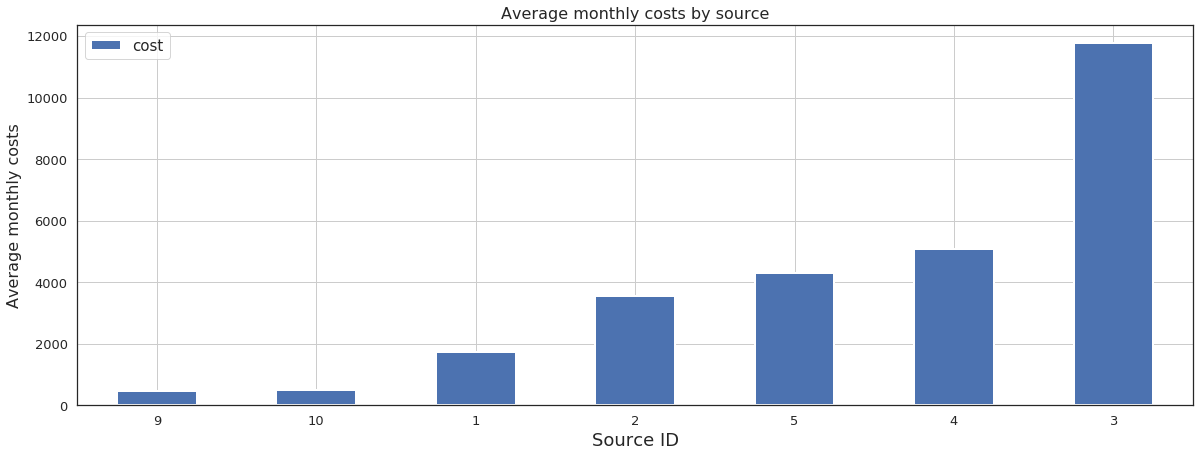

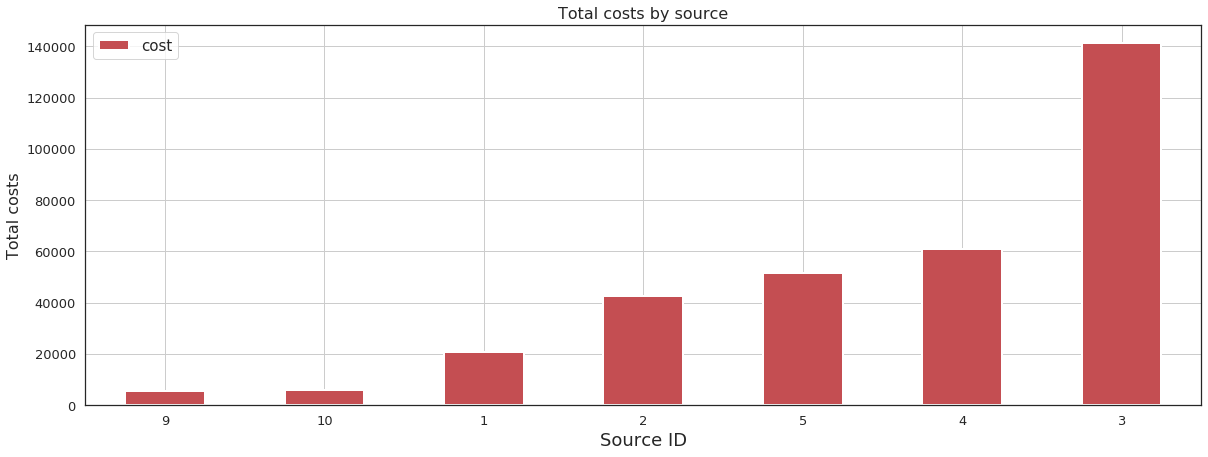

In [76]:
ax = average_monthly_source.plot(x = 'source_id', y = 'cost', figsize = (20, 7), grid = True, fontsize = 13, linewidth = 2, kind = 'bar', rot = 0)
plt.xlabel('Source ID', fontsize=18)
plt.ylabel('Average monthly costs', fontsize=16)
plt.title('Average monthly costs by source', fontsize=16)
plt.legend(prop={'size': 15})

ax = total_source.plot(x = 'source_id', y = 'cost', figsize = (20, 7), grid = True, fontsize = 13, linewidth = 2, kind = 'bar', rot = 0, color = 'r')
plt.xlabel('Source ID', fontsize=18)
plt.ylabel('Total costs', fontsize=16)
plt.title('Total costs by source', fontsize=16)
plt.legend(prop={'size': 15})
plt.show()

In [77]:
sources_months = costs.groupby(['source_id', 'month']).agg({'cost':'sum'}).reset_index()
sources_months = sources_months.pivot_table(index = 'source_id', columns = 'month', values = 'cost', aggfunc = 'mean')

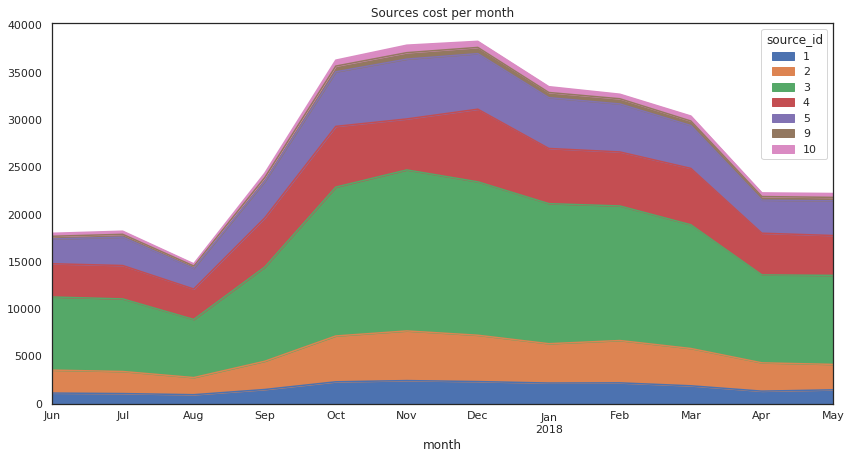

In [78]:
(costs.pivot_table(index = 'month', columns = 'source_id', values = 'cost', aggfunc = 'sum')
      .plot.area(figsize=(14,7), title='Sources cost per month'))
plt.show()

**In the area graph, we can easily see the "Financially area" each of the sources take from the total costs. 
We can see that for each month source 3 takes the highest volume of our costs followed by source 4 and 5.
We need to look if the income from this sources attract enogh clients.
source 1, 9 and 10 cost much less and we need to see how to imrove them or invest the ad money on other sources**

####  Cost of customer acquisition

In [79]:
print('mean CAC:', round(costs['cost'].sum() / orders_log['user_id'].nunique(), 2))

mean CAC: 9.01


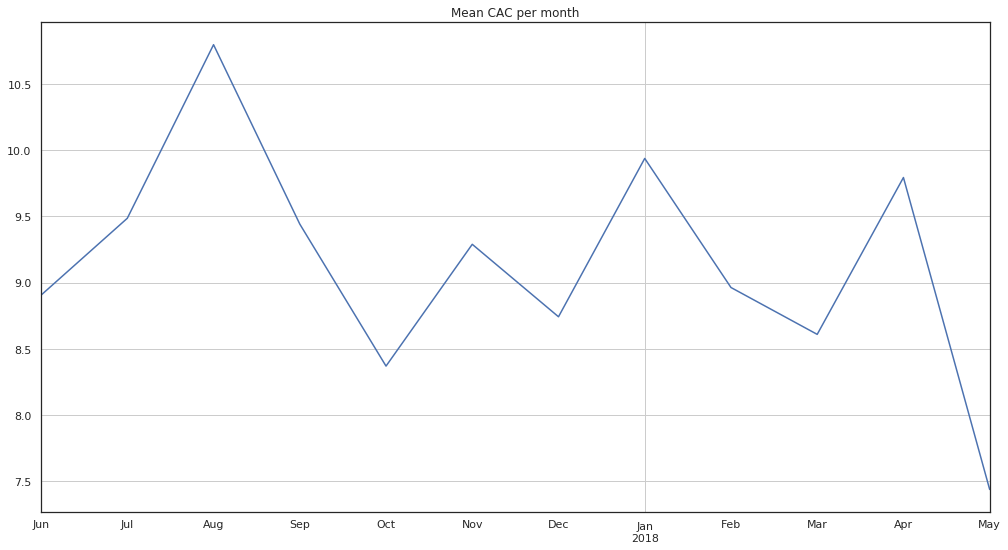

In [80]:
first_orders = orders_log.groupby('user_id').agg({'buy_ts': 'min'}).reset_index()
first_orders.columns = ['user_id', 'first_order_ts']
first_orders['first_order_dt'] = first_orders['first_order_ts'].dt.date
first_orders['first_order_month'] = first_orders['first_order_ts'].astype('datetime64[M]')

СAC_by_month = pd.merge(costs.groupby('month').agg({'cost': 'sum'}), 
                        first_orders.groupby('first_order_month').agg({'user_id': 'nunique'}), 
                        left_index=True, 
                        right_index=True)
СAC_by_month['CAC'] = СAC_by_month['cost']  / СAC_by_month['user_id'] 

СAC_by_month['CAC'].plot(figsize=(17,9), title='Mean CAC per month', grid = True)
plt.show()

In [81]:
first_sources = visits_log.sort_values('start_ts').groupby('user_id').first()

In [82]:
first_sources = first_sources[['source_id']]
orders_sources = pd.merge(first_orders, first_sources, left_on='user_id', right_index=True)

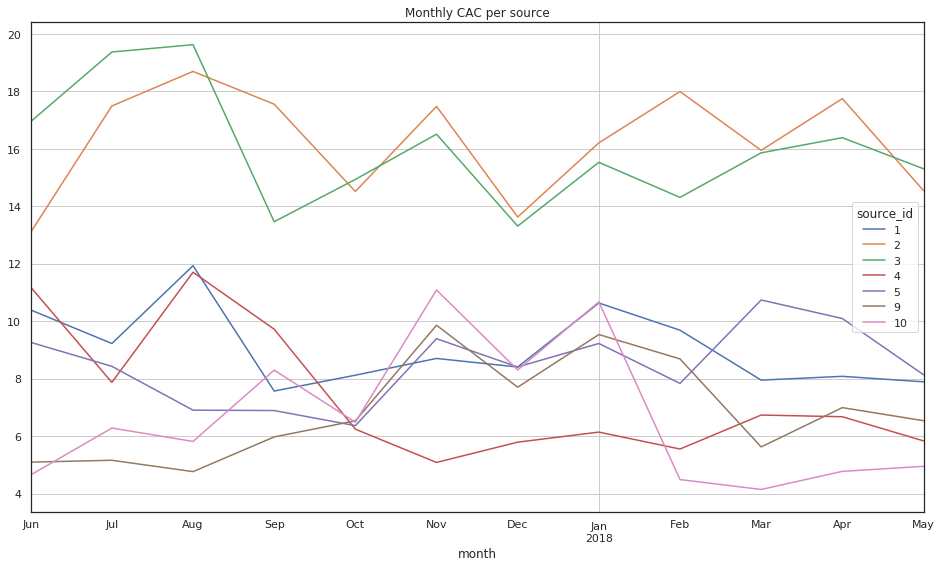

In [83]:
buyers_daily = orders_sources.groupby(['source_id', 'first_order_dt']).agg({'user_id': 'count'}).reset_index()
buyers_daily.rename(columns={'user_id': 'n_buyers'}, inplace = True)
buyers_daily['first_order_dt'] = pd.to_datetime(buyers_daily['first_order_dt'])

cac_per_source = pd.merge(buyers_daily, costs, left_on = ['source_id', 'first_order_dt'], right_on = ['source_id', 'date'])
cac_per_source['costs_per_buyer'] = cac_per_source['cost'] / cac_per_source['n_buyers']

cac_per_source.pivot_table(index=['month'], columns = 'source_id', values = 'costs_per_buyer', aggfunc = 'mean').plot(
    figsize=(16,9), title = 'Monthly CAC per source', grid = True)
plt.show()

In [84]:
mean_cac = cac_per_source.groupby('source_id')['n_buyers', 'cost'].sum().reset_index()
mean_cac['mean_CAC'] = mean_cac['cost'] / mean_cac['n_buyers']

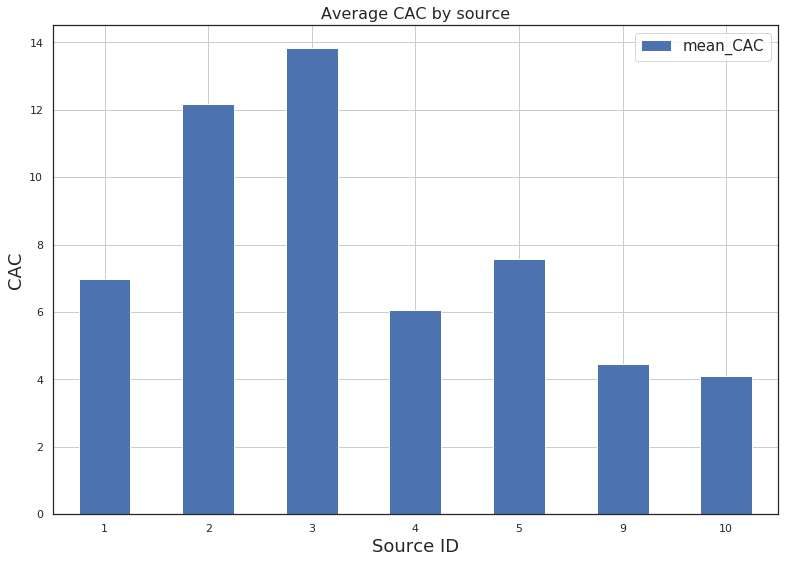

In [85]:
ax = mean_cac.plot(kind = 'bar', x = 'source_id', y = 'mean_CAC', rot = 0, figsize = (13, 9), grid = True)
plt.xlabel('Source ID', fontsize=18)
plt.ylabel('CAC', fontsize=18)
plt.title('Average CAC by source', fontsize=16)
plt.legend(prop={'size': 15})
plt.show()

##### Coclusion

**The monthly CAC reaches its peak in the summer months and later drops in october, reaches another significant peak at january and april. then have a big drop in may.
we can again see the CAC of source 3 is the highest and source 2 not far behind. the difference is source 2 brings in the highest LTV, at lest we can say source 2 gives value for its cost**

##### ROMI

In [86]:
monthly_costs['month'] = monthly_costs['month'].astype('datetime64[M]')

In [87]:
costs_report = pd.merge(report, monthly_costs, left_on='first_order_month', right_on='month')
costs_report['cac'] =  costs_report['cost'] / costs_report['n_buyers']

In [88]:
costs_report['romi'] = costs_report['ltv'] / costs_report['cac']
table = costs_report.pivot_table(index='first_order_month', columns='age', values='romi', aggfunc='mean')
output = table.cumsum(axis=1).round(2) 
output.index = output.index.date

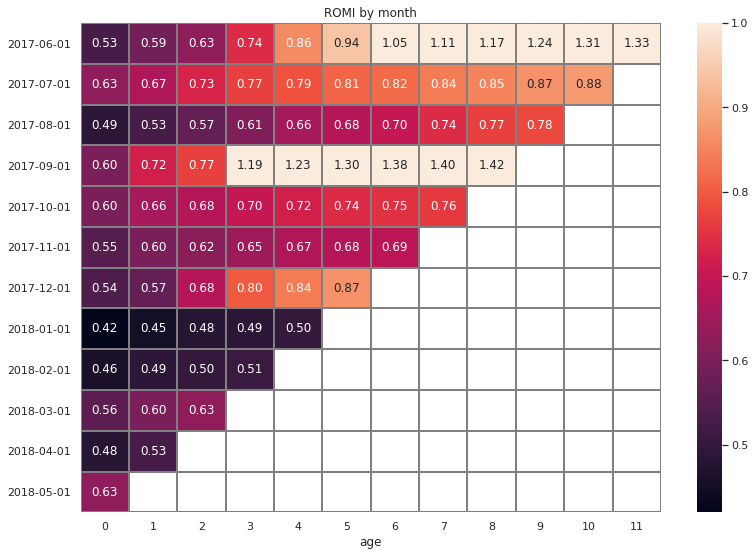

age
0     0.540816
1     0.581985
2     0.631069
3     0.719740
4     0.782946
5     0.859876
6     0.896819
7     0.969951
8     1.053871
9     0.964488
10    1.094658
11    1.333982
dtype: float64


In [89]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('ROMI by month')
sns.heatmap(output, annot=True, fmt='.2f', linewidths = 1, linecolor = 'gray', vmax = 1)
plt.show()

print(table.cumsum(axis=1).mean(axis=0) )

**In the ROMI heatmap we can easily see that we have successfully returned the investments on cost only in June and September 2017, while we are very far from full return in all the months of 2018 and comparing them to June and September 2017 they are not going to get us full return. We can see that the average time the cohort pays off is towards the end of the 8th month.**

In [90]:
first_orders = orders_log.groupby('user_id').agg({'purchase_month': 'min'}).reset_index()
first_orders.columns = ['user_id', 'first_order_month']
first_orders = first_orders.merge(first_sources, on = 'user_id')

In [91]:
cohort_sizes = first_orders.groupby(['source_id', 'first_order_month']).agg({'user_id': 'nunique'}).reset_index()
cohort_sizes.columns = ['source_id', 'first_order_month', 'n_buyers']

In [92]:
purchases = pd.merge(orders_log, first_orders, on = 'user_id')
cohorts = purchases.groupby(['source_id', 'first_order_month','purchase_month']).agg({'revenue': 'sum'}).reset_index()

In [93]:
report = pd.merge(cohort_sizes, cohorts, on = ['source_id', 'first_order_month'])

In [94]:
report['age'] = (report['purchase_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report['ltv'] = report['revenue'] / report['n_buyers']

In [95]:
monthly_costs = costs.groupby(['source_id', 'month'])['cost'].sum().reset_index()

In [96]:
costs_report = pd.merge(report, monthly_costs, left_on = ['source_id', 'first_order_month'], right_on = ['source_id', 'month'])

In [97]:
costs_report['cac'] =  costs_report['cost'] / costs_report['n_buyers']

In [98]:
costs_report['romi'] = costs_report['ltv'] / costs_report['cac']

In [99]:
source_1_romi = costs_report.query('source_id == 1')
source_2_romi = costs_report.query('source_id == 2 ')
source_3_romi = costs_report.query('source_id == 3')
source_4_romi = costs_report.query('source_id == 4')
source_5_romi = costs_report.query('source_id == 5')
source_9_romi = costs_report.query('source_id == 9')
source_10_romi = costs_report.query('source_id == 10')

In [100]:
source_1_table = source_1_romi.pivot_table(index='first_order_month', columns='age', values='romi', aggfunc='mean')
source_1_output = source_1_table.cumsum(axis=1).round(2)
source_1_output.index = source_1_output.index.date
source_2_table = source_2_romi.pivot_table(index='first_order_month', columns='age', values='romi', aggfunc='mean')
source_2_output = source_2_table.cumsum(axis=1).round(2)
source_2_output.index = source_2_output.index.date
source_3_table = source_3_romi.pivot_table(index='first_order_month', columns='age', values='romi', aggfunc='mean')
source_3_output = source_3_table.cumsum(axis=1).round(2)
source_3_output.index = source_3_output.index.date
source_4_table = source_4_romi.pivot_table(index='first_order_month', columns='age', values='romi', aggfunc='mean')
source_4_output = source_4_table.cumsum(axis=1).round(2)
source_4_output.index = source_4_output.index.date
source_5_table = source_5_romi.pivot_table(index='first_order_month', columns='age', values='romi', aggfunc='mean')
source_5_output = source_5_table.cumsum(axis=1).round(2) 
source_5_output.index = source_5_output.index.date
source_9_table = source_9_romi.pivot_table(index='first_order_month', columns='age', values='romi', aggfunc='mean')
source_9_output = source_9_table.cumsum(axis=1).round(2) 
source_9_output.index = source_9_output.index.date
source_10_table = source_10_romi.pivot_table(index='first_order_month', columns='age', values='romi', aggfunc='mean')
source_10_output = source_10_table.cumsum(axis=1).round(2) 
source_10_output.index = source_10_output.index.date

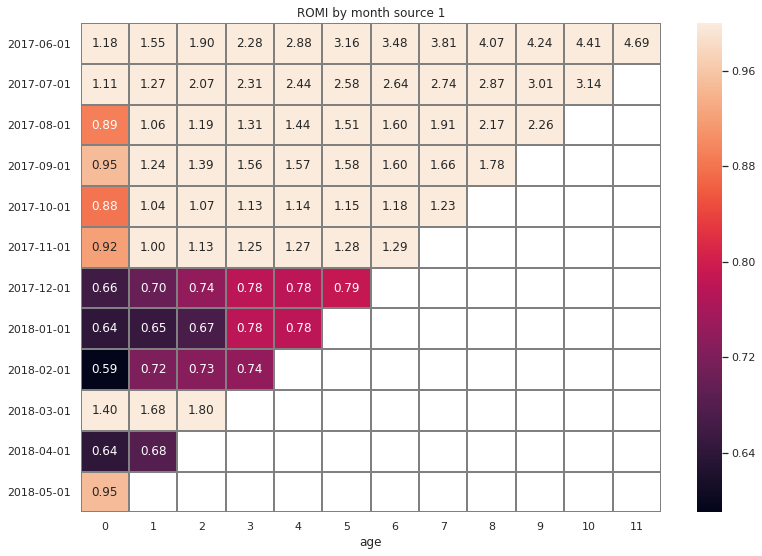

age
0     0.901911
1     1.054050
2     1.269412
3     1.346856
4     1.537110
5     1.722742
6     1.965722
7     2.269692
8     2.720532
9     3.171345
10    3.776705
11    4.691270
dtype: float64


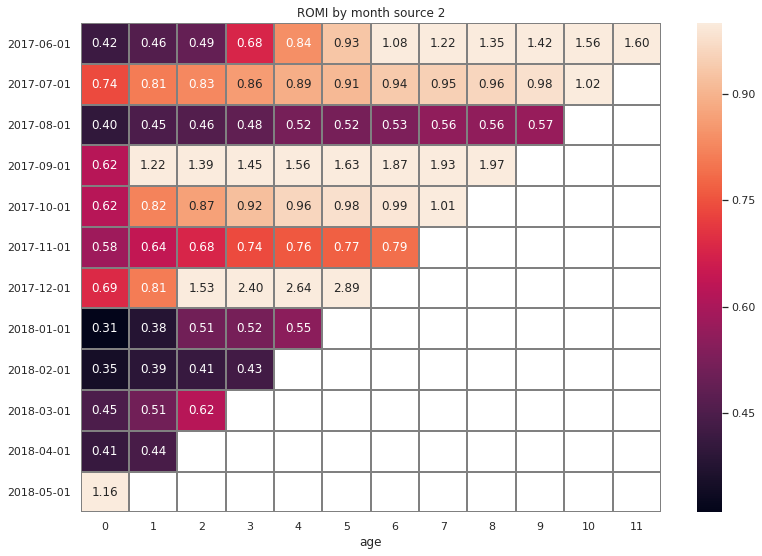

age
0      0.562500
1      1.138182
2      1.946000
3      2.928889
4      4.187500
5      5.694286
6      5.850000
7      7.162000
8      8.370000
9      7.603333
10    10.170000
11    12.050000
dtype: float64


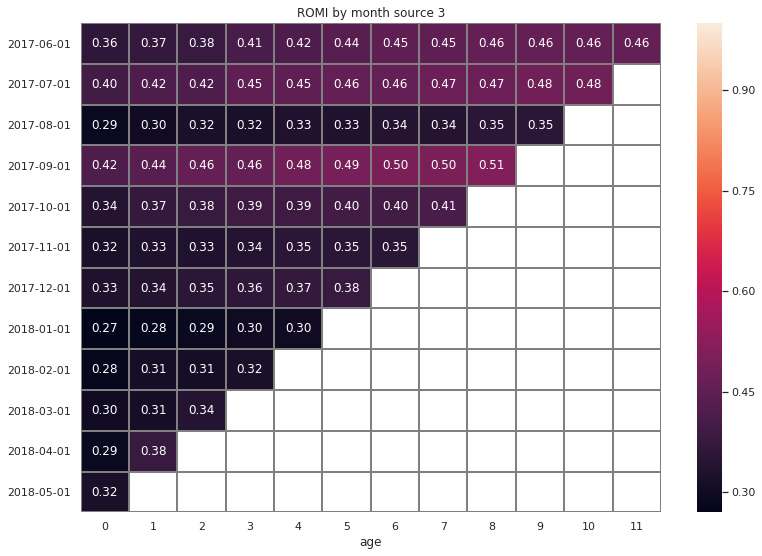

age
0     0.327787
1     0.350351
2     0.359398
3     0.372489
4     0.387632
5     0.406720
6     0.416439
7     0.434724
8     0.446528
9     0.429165
10    0.471244
11    0.464612
dtype: float64


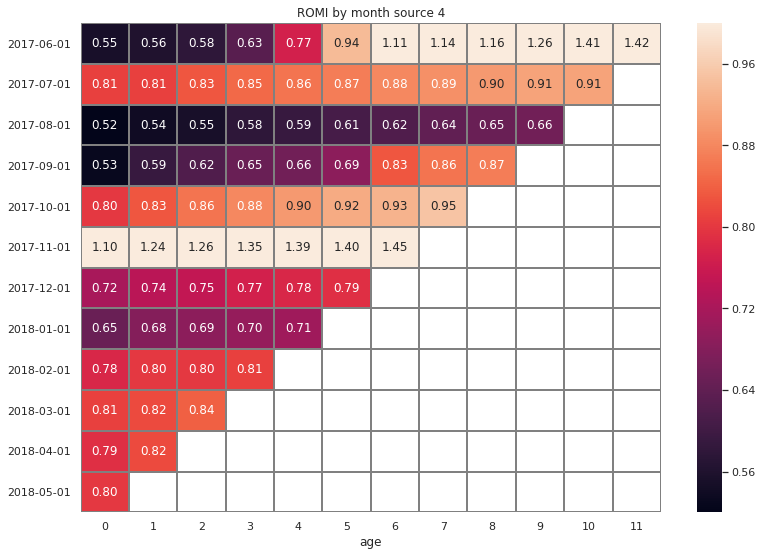

age
0     0.737997
1     0.765452
2     0.778180
3     0.801863
4     0.831521
5     0.888467
6     0.971303
7     0.894528
8     0.894408
9     0.942405
10    1.158120
11    1.415284
dtype: float64


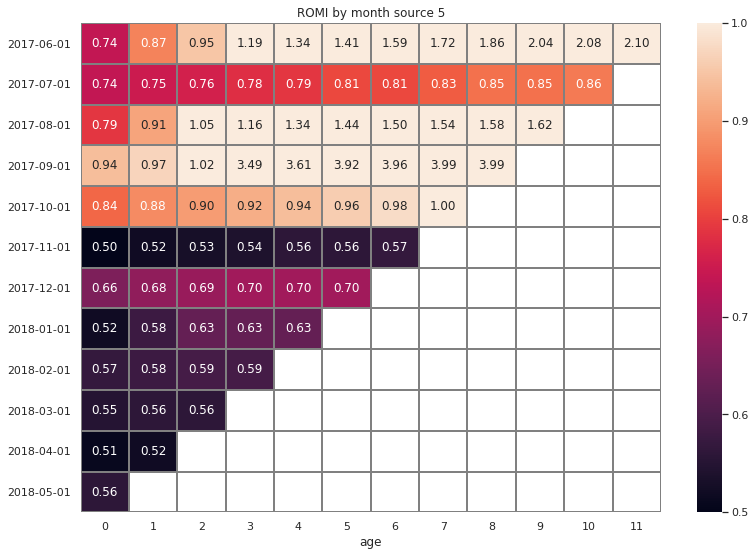

age
0     0.660806
1     0.711724
2     0.768436
3     1.111800
4     1.239180
5     1.399893
6     1.570164
7     1.817274
8     2.068820
9     1.505194
10    1.467301
11    2.100271
dtype: float64


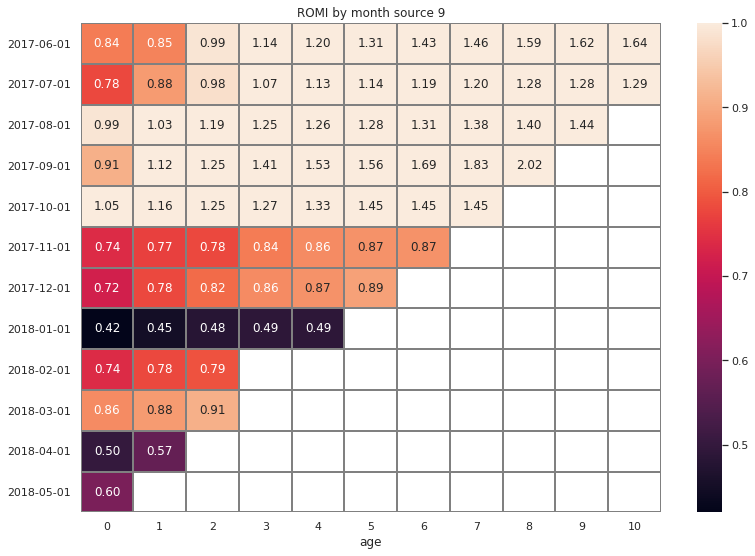

age
0     0.762178
1     0.844116
2     0.944877
3     1.041297
4     1.085367
5     1.213603
6     1.324540
7     1.465659
8     1.571911
9     1.446754
10    1.466294
dtype: float64


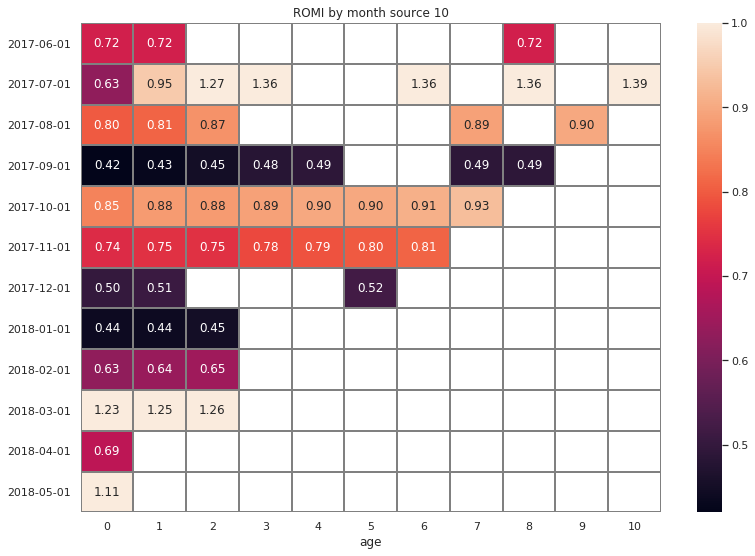

age
0     0.901911
1     1.054050
2     1.269412
3     1.346856
4     1.537110
5     1.722742
6     1.965722
7     2.269692
8     2.720532
9     3.171345
10    3.776705
11    4.691270
dtype: float64


In [101]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('ROMI by month source 1')
sns.heatmap(source_1_output, annot=True, fmt='.2f', linewidths = 1, linecolor = 'gray', vmax = 1)
plt.show()

print(source_1_table.cumsum(axis=1).mean(axis=0) )

sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('ROMI by month source 2')
sns.heatmap(source_2_output, annot=True, fmt='.2f', linewidths = 1, linecolor = 'gray', vmax = 1)
plt.show()

print(source_2_output.cumsum(axis=1).mean(axis=0) )

sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('ROMI by month source 3')
sns.heatmap(source_3_output, annot=True, fmt='.2f', linewidths = 1, linecolor = 'gray', vmax = 1)
plt.show()

print(source_3_table.cumsum(axis=1).mean(axis=0) )

sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('ROMI by month source 4')
sns.heatmap(source_4_output, annot=True, fmt='.2f', linewidths = 1, linecolor = 'gray', vmax = 1)
plt.show()

print(source_4_table.cumsum(axis=1).mean(axis=0) )

sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('ROMI by month source 5')
sns.heatmap(source_5_output, annot=True, fmt='.2f', linewidths = 1, linecolor = 'gray', vmax = 1)
plt.show()

print(source_5_table.cumsum(axis=1).mean(axis=0) )

sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('ROMI by month source 9')
sns.heatmap(source_9_output, annot=True, fmt='.2f', linewidths = 1, linecolor = 'gray', vmax = 1)
plt.show()

print(source_9_table.cumsum(axis=1).mean(axis=0) )

sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('ROMI by month source 10')
sns.heatmap(source_10_output, annot=True, fmt='.2f', linewidths = 1, linecolor = 'gray', vmax = 1)
plt.show()

print(source_1_table.cumsum(axis=1).mean(axis=0) )

**We can see that sources 1 and 2 return their investment very quickly. On average they return it after around 2 months.
Sources 5 and 9 are not far behind with 4 months. Source 4 has fairly high averagge number of months to return the investment with 11 months while source number 3 did not return the investment even once. It only barley returned 50% of the investment on the cohort of september 2017 and it was its highest value.
Source 10 has lots of missing age groups s we can't properly analyse it. That being said, we can still see it does has potential but maybe it doesn't reaches enough potential users so we don't have enough age groups to fill in the heatmap.**

## Conclusion

### Product:

In [102]:
print('DAU = {:.2f}'.format(dau_num))
print('WAU = {:.2f}'.format(wau_num))
print('MAU = {:.2f}'.format(mau_num))

print('')

print('Daily average sessions = {:.2f}'.format(daily_avg_num))
print('Daily average sessions on desktop = {:.2f}'.format(desktop_avg_num))
print('Daily average session length on desktop = {:.2f}'.format(desktop_avg_len_num))
print('Daily average sessions on touch = {:.2f}'.format(touch_avg_num))
print('Daily average session length on touch = {:.2f}'.format(touch_avg_len_num))

DAU = 816.51
WAU = 4420.10
MAU = 20946.33

Daily average sessions = 886.45
Daily average sessions on desktop = 1.09
Daily average session length on desktop = 11.96
Daily average sessions on touch = 1.05
Daily average session length on touch = 8.69


**Our product attracts on average around 816 visits daily, 4420 monthly and 21,000 users monthly. most of the users only visit our site once a day on every day they visited our site. more users use destop and the desktop users spend more time in our site.
The retention by source shows us that users who come from sources 1,2 and 9 are the most likley to return.**

### Sales

In [103]:
print('percentage of users who purchase on their first visit: {:.2%}'.format(len(conversion_time[conversion_time['conversion_time'] == 0]) / len(conversion_time)))

percentage of users who purchase on their first visit: 77.74%


**77.74% of the purchases occure in the first day of visit in the website. looks like our funnels work pretty well and direct the customers to the product they want very efficiently.
The conversion time of source 9 is very high and we need to check the value of it, while sources 1 and 10 have lower conversion times so they probably work well.
The conversion time on desktops is slightly lower than on touch. Maybe the touch platform need some fixes.**
**

**our customers make around 2 purchases every month with average purchase size of around 7 dollars each. it probably depends on our product which is not something you need on daily bases.**

**We have higher LTV for customers who made their first purchase in June, September and December 2017, And sources 1 and 2 produce the highest LTV for coustomers.**

### Marketing

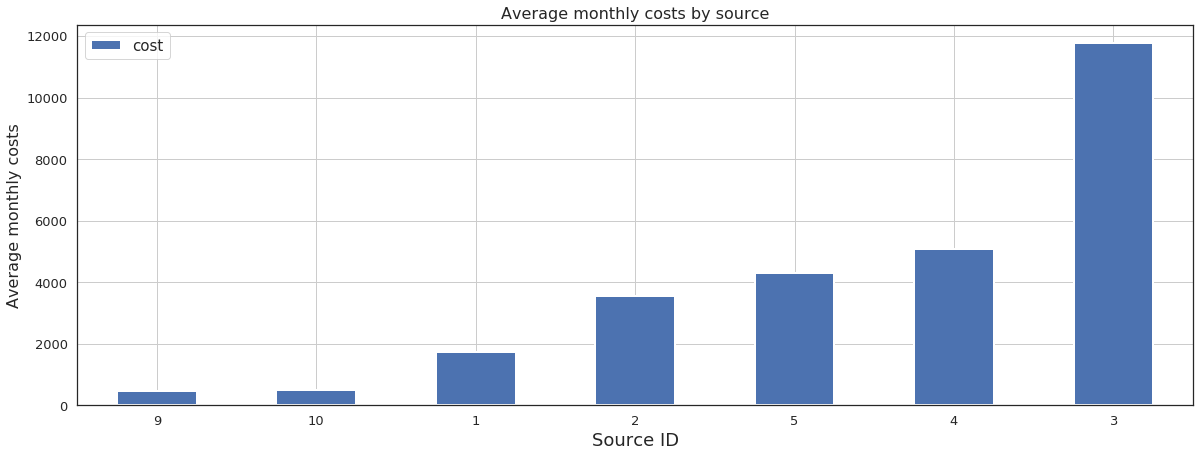

In [104]:
ax = average_monthly_source.plot(x = 'source_id', y = 'cost', figsize = (20, 7), grid = True, fontsize = 13, linewidth = 2, kind = 'bar', rot = 0)
plt.xlabel('Source ID', fontsize=18)
plt.ylabel('Average monthly costs', fontsize=16)
plt.title('Average monthly costs by source', fontsize=16)
plt.legend(prop={'size': 15})
plt.show()

In [105]:
total_sources = pd.DataFrame(data = purchases.groupby('source_id')['user_id'].nunique())

In [106]:
total_sources['percentage'] = ((total_sources['user_id'] / total_sources['user_id'].sum()) * 100).round(decimals = 2)

In [107]:
total_sources.set_axis(['num_of_purchases', 'percentage'], axis = 1, inplace = True)
total_sources.query('source_id != 7').sort_values(by = 'percentage', ascending = False)

,num_of_purchases,percentage
source_id,,
3,10224,28.36
4,10096,28.01
5,6847,18.99
2,3518,9.76
1,2972,8.24
10,1308,3.63
9,1083,3.00


**The most concerning thing about the marketing is source 3. We couldn't see any ROMI in the past 12 months while it is the source we invest the highest volume of our marketnig budget.
Even though it dosen't return the investment, it is still the source that brings the most users. We need to find a way to reduse CAC on source 3 or stop using it.**

**Source 4 is the 2nd on the list  with 28% of the users while having less than a half of the average monthly cost comparing to source 3. although it takes more time for it to return the investment, we can see a steady growth in the heatmap.** 

**Source 5 has brought 19% and returns the investment quick at around4 months.**

**Sources 1 and 2 are stable with lesser percentage of users but return their investment very quickly.**

**Sources 9 and 10 return the investment very quick but have low percentage of users coming from them. Maybe we can increase the volume of ads on this sources.**

